# Planar.ai Code

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.base import clone
%matplotlib inline

## Survey Feedback System
Goal : Determine the likelyhood of an employee coming to work in-person on a certain day of the week.

Survey Link : https://docs.google.com/forms/d/1tbhFI7JkYJxe8bbO3fN_p8H5UTHRajab9fa2lioqtQM/edit?usp=sharing

### Creating Sample Survey Response Dataset

In [98]:
num_samples = 1000

survey_df = pd.DataFrame(columns = ["age", "years_in_comapny","commute_duration", "hours_in_office", "days_in_office", 
                                    "num_coworkers_speak","social_interaction_level", 
                                    "private_room?", "social_room?", "cafe?", "likely_return", "happiness_score", "productivity_level"])
for sample in range(num_samples):
    age = np.random.choice(range(21,56))
    years_in_company = np.random.choice(range(1,25))
    commute_duration = np.random.choice(range(1,4))
    hours_in_office = np.random.choice(range(1,13))
    days_in_office = np.random.choice(range(1,6))
    num_coworkers_speak = np.random.choice(range(1,21))
    social_interaction_level = np.random.choice(range(1,6))
    private_room = np.random.choice(range(0,2))
    social_room = np.random.choice(range(0,2))
    cafe = np.random.choice(range(0,2))
    likely_return = np.random.choice(range(0,10))
    happiness_score = np.random.choice(range(0,10))
    productivity_level = np.random.choice(range(0,10))
    survey_df.loc[len(survey_df)] = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, social_interaction_level,private_room,
                                 social_room, cafe, likely_return, happiness_score, productivity_level]
survey_df 

,age,years_in_comapny,commute_duration,hours_in_office,days_in_office,num_coworkers_speak,social_interaction_level,private_room?,social_room?,cafe?,likely_return,happiness_score,productivity_level
0,23,16,3,4,1,14,2,0,0,0,3,9,3
1,48,19,3,3,4,2,5,0,1,1,3,4,0
2,29,10,3,7,2,17,3,1,1,1,5,5,7
3,30,15,1,6,5,14,1,1,1,0,1,6,1
4,36,9,1,2,2,12,1,0,0,0,7,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22,10,3,10,1,7,1,1,1,1,8,9,8
996,43,13,2,6,3,17,3,1,1,1,7,2,3
997,40,10,2,2,2,5,4,0,1,1,5,0,1
998,36,6,1,9,3,10,2,0,0,1,7,1,2


### Splitting Data 

In [114]:
def split_data(pred_col):
    X_train, X_test, y_train, y_test = train_test_split(survey_df.drop(columns = [pred_col]), survey_df[pred_col], test_size=0.33)
    return [X_train, X_test, y_train, y_test]

lr_split = split_data("likely_return")    
hs_split = split_data("happiness_score")
pl_split = split_data("productivity_level")
    

### Generating Model

In [106]:
class OrdinalClassifier():
    
    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}
    
    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                clf.fit(X, binary_y)
                self.clfs[i] = clf
    
    def predict_proba(self, X):
        clfs_predict = {k:self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i,y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[y][:,1])
            elif y in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[y-1][:,1] - clfs_predict[y][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[y-1][:,1])
        return np.vstack(predicted).T
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

###  Model Hyperparameter Tuning

In [110]:
def tune_model(depth_range, var_split, pred_col):
    X_train, X_test, y_train, y_test = var_split
    train_accs = []
    test_accs = []
    depths = depth_range
    for depth in depths:  
        clf = OrdinalClassifier(DecisionTreeClassifier(max_depth = depth))
        clf.fit(X_train, y_train)
        train_preds = clf.predict(X_train)
        test_preds = clf.predict(X_test)
        train_accs.append(accuracy_score(train_preds, y_train))
        test_accs.append(accuracy_score(test_preds, y_test))
    plt.figure(figsize = (10,8))
    plt.plot(depths, train_accs, label = "Training Accuracy")
    plt.plot(depths, test_accs, label = "Testing Accuracy")
    plt.xlabel("Model Tree Depth")
    plt.ylabel("Model Accuracy")
    plt.title("Model Accuracy with Varying Depth for " + pred_col);
    best_train_depth = np.argmax(train_accs) + 1
    best_test_depth = np.argmax(test_accs) + 1
    print("Best Training Accuracy at depth =", best_train_depth, "for", pred_col)
    print("Best Testing Accuracy at depth =", best_test_depth, "for", pred_col)
    return best_train_depth, best_test_depth

Best Training Accuracy at depth = 17 for Likely Return
Best Testing Accuracy at depth = 3 for Likely Return
Best Training Accuracy at depth = 20 for Happiness Score
Best Testing Accuracy at depth = 29 for Happiness Score
Best Training Accuracy at depth = 20 for Productivity Level
Best Testing Accuracy at depth = 20 for Productivity Level


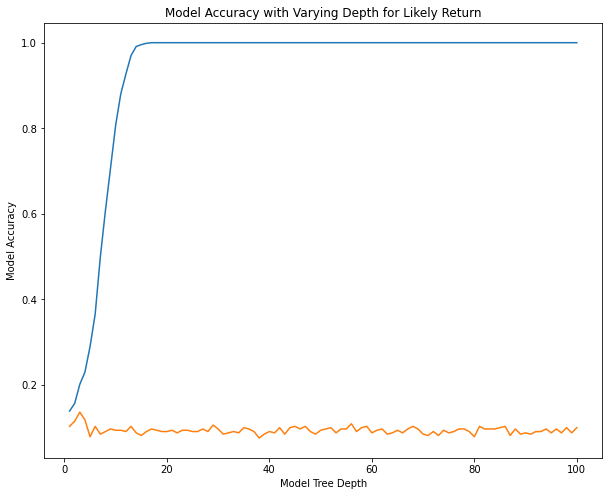

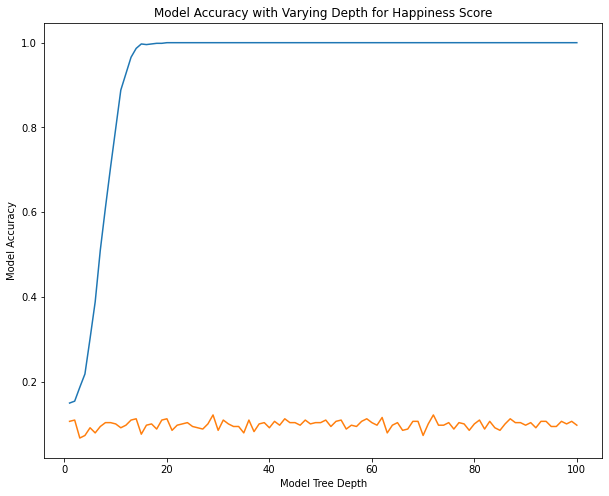

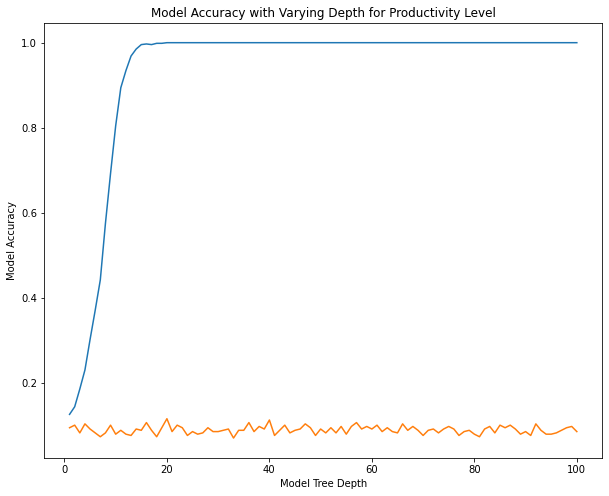

In [115]:
best_train_depth_lr, best_test_depth_lr = tune_model(range(1,101), lr_split, "Likely Return")
best_train_depth_hs, best_test_depth_hs = tune_model(range(1,101), hs_split, "Happiness Score")
best_train_depth_pl, best_test_depth_pl = tune_model(range(1,101), pl_split, "Productivity Level")

### Output Final Model

In [119]:
def train_model(best_depth, train_split):
    X_train, y_trian = train_split
    clf = OrdinalClassifier(DecisionTreeClassifier(max_depth = best_depth))
    clf.fit(X_train, y_train)
    return clf

In [127]:
best_model_lr = train_model(best_test_depth_lr, lr_split[:2])
best_model_hs = train_model(best_test_depth_hs, hs_split[:2])
best_model_pl = train_model(best_test_depth_pl, pl_split[:2])

### Predict Likelyhood for New User

In [132]:
age = 24
years_in_company = 3
commute_duration = 1
hours_in_office = 6
days_in_office = 5
num_coworkers_speak = 6
productivity_level = 4
social_interaction_level = 5
private_room = 4
social_room = 1
cafe = 1
happiness_score = 9
productivity_level = 3

new_test_lr = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, social_interaction_level,private_room,
                                 social_room, cafe, happiness_score, productivity_level]
new_prediction_lr = best_model_lr.predict(np.array(new_test_lr).reshape(1,-1))[0] + 1
print("This new user's predicted likelyhood of returning to the office on the same day next week is", new_prediction_lr, "on a scale of 1-10")


This new user's predicted likelyhood of returning to the office on the same day next week is 3 on a scale of 1-10


### Predict Happiness Score for New User

In [133]:
age = 24
years_in_company = 3
commute_duration = 3
hours_in_office = 6
days_in_office = 5
num_coworkers_speak = 7
productivity_level = 4
social_interaction_level = 5
private_room = 0
social_room = 1
cafe = 1
likely_return = 7
productivity_level = 3

new_test_hs = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, social_interaction_level,private_room,
                                 social_room, cafe, likely_return, productivity_level]
new_prediction_hs = best_model_hs.predict(np.array(new_test_hs).reshape(1,-1))[0] + 1
print("This new user's predicted happiness score is", new_prediction_hs, "on a scale of 1-10")


This new user's predicted happiness score is 2 on a scale of 1-10


### Predict Happiness Score for New User

In [130]:
age = 24
years_in_company = 3
commute_duration = 1
hours_in_office = 6
days_in_office = 5
num_coworkers_speak = 6
productivity_level = 4
social_interaction_level = 5
private_room = 0
social_room = 1
cafe = 1
likely_return = 7
happiness_score = 4

new_test_pl = [age, years_in_company,commute_duration,hours_in_office,days_in_office,
                                  num_coworkers_speak, social_interaction_level,private_room,
                                 social_room, cafe, likely_return, happiness_score]
new_prediction_pl = best_model_pl.predict(np.array(new_test_pl).reshape(1,-1))[0] + 1
print("This new user's predicted productivity level is", new_prediction_pl, "on a scale of 1-10")


This new user's predicted productivity level is 5 on a scale of 1-10
